In [1]:
import numpy as np
np.set_printoptions(precision=4)
from pathlib import Path
import mujoco
import matplotlib.pyplot as plt
import logging
from scipy.spatial import ConvexHull, convex_hull_plot_2d, QhullError
import itertools
import pandas as pd
import cvxopt as cvx

In [2]:
contact_data_dir = "27032024-122512" # Frames not translated
#contact_data_dir = "27032024-123056" # Frames translated

In [3]:
def cvx_vol(all_coordinates):
    try:
        hull = ConvexHull(all_coordinates)
        return hull.volume, True    
    except (QhullError, ValueError):
        return 0.0, False

In [4]:
def wrench_rank(wrenches):
    try:
        return np.linalg.matrix_rank(wrenches)
    except ValueError:
        return 0

In [5]:
# This code is adapted from DexNet at https://github.com/BerkeleyAutomation/dex-net/blob/master/src/dexnet/grasping/quality.py#L670

def min_norm_vector_in_facet(facet, wrench_regularizer=1e-10):
        dim = facet.shape[1] # num vertices in facet

        # create alpha weights for vertices of facet
        G = facet.T.dot(facet)
        grasp_matrix = G + wrench_regularizer * np.eye(G.shape[0])

        # Solve QP to minimize .5 x'Px + q'x subject to Gx <= h, Ax = b
        P = cvx.matrix(2 * grasp_matrix)   # quadratic cost for Euclidean dist
        q = cvx.matrix(np.zeros((dim, 1)))
        G = cvx.matrix(-np.eye(dim))       # greater than zero constraint
        h = cvx.matrix(np.zeros((dim, 1)))
        A = cvx.matrix(np.ones((1, dim)))  # sum constraint to enforce convex
        b = cvx.matrix(np.ones(1))         # combinations of vertices

        sol = cvx.solvers.qp(P, q, G, h, A, b)
        v = np.array(sol['x'])
        min_norm = np.sqrt(sol['primal objective'])

        return abs(min_norm), v

def epsilon(wrenches, wrench_norm_thresh=20, wrench_regularizer=1e-10):
    G = wrenches

    try:
        hull = ConvexHull(wrenches)
    
        if len(hull.simplices) == 0:
            print('Convex hull could not be computed')
            return 0.0, False, 'Convex hull could not be computed'
    
        # determine whether or not zero is in the convex hull
        min_norm_in_hull, v = min_norm_vector_in_facet(G, wrench_regularizer=wrench_regularizer)
    
        print(f"min_norm_in_hull: {min_norm_in_hull} -- v:{v}")
        
        # if norm is greater than 0 then forces are outside of hull
        if min_norm_in_hull > wrench_norm_thresh:
            print('Zero not in convex hull')
            return 0.0, False, 'Zero not in convex hull'
    
        # if there are fewer nonzeros than D-1 (dim of space minus one)
        # then zero is on the boundary and therefore we do not have
        # force closure
        if np.sum(v > 1e-4) <= G.shape[0]-1:
            print('Zero not in interior of convex hull')
            return 0.0, False, 'Zero not in interior of convex hull'
    
        # find minimum norm vector across all facets of convex hull
        min_dist = sys.float_info.max
        closest_facet = None
        for v in hull.simplices:
            if np.max(np.array(v)) < G.shape[1]: # because of some occasional odd behavior from pyhull
                facet = G[:, v]
                dist, _ = min_norm_vector_in_facet(facet, wrench_regularizer=wrench_regularizer)
                if dist < min_dist:
                    min_dist = dist
                    closest_facet = v
        return min_dist, True, "Success"
    except (QhullError, ValueError) as e:
        return 0.0, False, e

In [6]:
axes = ["x", "y"]
angles = np.arange(-np.pi/6, np.pi/6+np.pi/18, step=np.pi/18)
cloth_names = [0]
column_names = ["cloth", "axis", "angle", "num_points", "points_cvx_vol", 
                "points_cvx_vol_exists", "wrench_rank", "wench_vol", 
                "epsilon", "epsilon_exists", 'e_msg']
data = []
for cloth_name in cloth_names:
    angles = np.rad2deg(np.arange(-np.pi/6, np.pi/6+np.pi/18, step=np.pi/18))
    combinations = itertools.product(['x', 'y'], angles)
    combinations = [(ax, ang) for ax, ang in combinations if ax == 'x' or ang != 0]
    for (axis, angle) in combinations:
        angle = f"{angle:.0f}"
        file_path = Path(contact_data_dir) / f"{cloth_name}_{axis}_{angle}.npy"
        scene_xml = Path("xmls") / f"{cloth_name}_scene.xml"

        model = mujoco.MjModel.from_xml_path(str(scene_xml.resolve()))
        left_finger_id = model.geom('gripper0_finger1_collision').id
        right_finger_id = model.geom('gripper0_finger2_collision').id

        contacts = np.load(file_path,allow_pickle='TRUE').item()
        left_finger_mask = ((contacts['geom'][:, 0] == left_finger_id) | (
                    contacts['geom'][:, 1] == left_finger_id))
        left_contact_points = np.nonzero(left_finger_mask)
        right_finger_mask = ((contacts['geom'][:, 0] == right_finger_id) | (
                    contacts['geom'][:, 1] == right_finger_id))
        right_contact_points = np.nonzero(right_finger_mask)
        left_contact_coordinates = contacts['pos'][left_contact_points]
        right_contact_coordinates = contacts['pos'][right_contact_points]
        all_coordinates = np.concatenate((left_contact_coordinates, right_contact_coordinates))

        cvx_volume, cvx_volume_success = cvx_vol(all_coordinates)
        e, epsilon_exists, e_msg = epsilon(contacts['forces'])
        wrench_vol, _ = cvx_vol(contacts['forces'])
        data.append([cloth_name, axis, angle, len(all_coordinates),
                            cvx_volume, cvx_volume_success, wrench_rank(contacts['forces']),
                            wrench_vol, e, epsilon_exists, e_msg])

     pcost       dcost       gap    pres   dres
 0:  1.3112e+02  1.3359e+02  8e+00  3e+00  4e+00
 1:  1.3156e+02  1.4126e+02  2e+00  1e+00  2e+00
 2:  3.1987e+02  1.6356e+02  2e+02  4e-16  7e-14
 3:  1.9723e+02  7.8206e+01  1e+02  1e-15  1e-13
 4:  1.9655e+02  1.9513e+02  1e+00  2e-16  3e-14
 5:  1.9631e+02  1.9630e+02  1e-02  1e-16  5e-14
 6:  1.9631e+02  1.9631e+02  1e-04  1e-16  4e-14
Optimal solution found.
min_norm_in_hull: 14.010958587064561 -- v:[[1.0000e+00]
 [2.1088e-07]]
Zero not in interior of convex hull
     pcost       dcost       gap    pres   dres
 0:  1.3129e+02  1.3275e+02  8e+00  3e+00  4e+00
 1:  1.3151e+02  1.3783e+02  2e+00  1e+00  2e+00
 2:  3.8102e+02  1.1598e+02  3e+02  7e-02  1e-01
 3:  1.8266e+02 -1.9499e+02  4e+02  6e-02  9e-02
 4:  1.8733e+02  1.8281e+02  5e+00  3e-04  5e-04
 5:  1.8663e+02  1.8659e+02  5e-02  3e-06  5e-06
 6:  1.8663e+02  1.8663e+02  5e-04  3e-08  5e-08
 7:  1.8663e+02  1.8663e+02  5e-06  3e-10  5e-10
Optimal solution found.
min_norm_in_hu

In [7]:
df = pd.DataFrame(data, columns=column_names)

In [9]:
def draw_images(cloth, axis, angle):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    for ax, camera in zip(axs, ['robot0_robotview', 'sideview', 'robot0_eye_in_hand']):
        contact_image = Path(contact_data_dir) / f"{cloth}_{axis}_{angle}_{camera}.png"
        ax.imshow(plt.imread(contact_image))
        ax.set_title(camera)
    plt.show()

In [10]:
sorted_df = df.sort_values(by=['wench_vol'], ascending=False)

In [11]:
sorted_df

,cloth,axis,angle,num_points,points_cvx_vol,points_cvx_vol_exists,wrench_rank,wench_vol,epsilon,epsilon_exists,e_msg
0,0,x,-30,2,0.0,False,2,56.564752,0.0,False,Zero not in interior of convex hull
4,0,x,10,2,0.0,False,2,49.441259,0.0,False,Zero not in interior of convex hull
11,0,y,10,2,0.0,False,2,47.201434,0.0,False,Zero not in interior of convex hull
6,0,x,30,2,0.0,False,2,38.292023,0.0,False,Zero not in interior of convex hull
3,0,x,0,2,0.0,False,2,37.552257,0.0,False,Zero not in interior of convex hull
1,0,x,-20,2,0.0,False,2,37.435611,0.0,False,Zero not in interior of convex hull
2,0,x,-10,2,0.0,False,2,33.431635,0.0,False,Zero not in interior of convex hull
5,0,x,20,2,0.0,False,2,28.728859,0.0,False,Zero not in interior of convex hull
7,0,y,-30,2,0.0,False,2,16.651480,0.0,False,Zero not in interior of convex hull
12,0,y,20,2,0.0,False,2,12.953318,0.0,False,Zero not in interior of convex hull


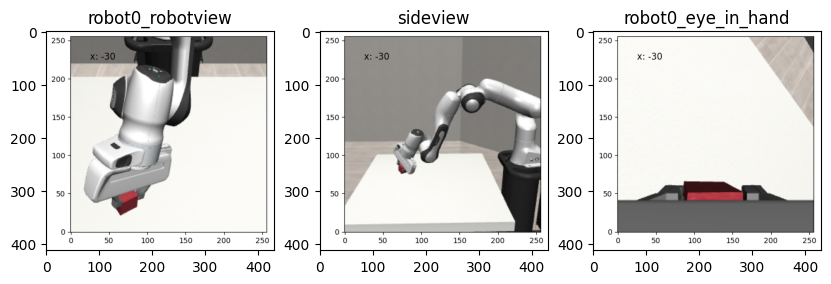

In [12]:
cloth, axis, angle = sorted_df.iloc[0].cloth, sorted_df.iloc[0].axis, sorted_df.iloc[0].angle

draw_images(cloth, axis, angle)

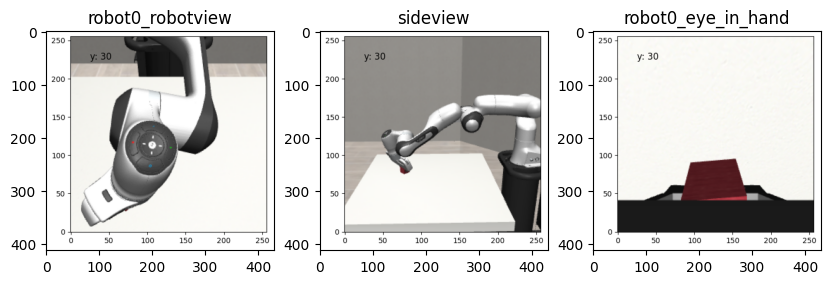

In [13]:
cloth, axis, angle = sorted_df.iloc[-1].cloth, sorted_df.iloc[-1].axis, sorted_df.iloc[-1].angle

draw_images(cloth, axis, angle)